# Convolution Neural Network in PyTorch

## Classification task

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01_a_pytorch_workflow.png" width="900px">


In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt

import os
import copy
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision
from torchvision import transforms, datasets
import torchvision.transforms as T

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from tqdm.notebook import tqdm, trange

import pandas as pd
try:  
    from torchinfo import summary
except:
    !pip install -U torchinfo
finally:    
    from torchinfo import summary

In [4]:
def torch_stats(): 
    torch_version = ".".join(torch.__version__.split(".")[:2])
    print('torch version:',torch_version)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device:', device)
    dtype = torch.float32
    
    if device.type == 'cuda':
        cuda_version  = torch.__version__.split("+")[-1]
        print("cuda: ", cuda_version)
        
        torch.set_default_tensor_type(torch.cuda.FloatTensor)
        print('Cuda is available:',torch.cuda.is_available())

        n_devices = torch.cuda.device_count()
        print('number of devices: %d'%(n_devices))

        for cnt_device in range(n_devices):
            print(torch.cuda.get_device_name(cnt_device))
            print('Memory Usage:')
            print('Allocated:', round(torch.cuda.memory_allocated(cnt_device)/1024**3,1), 'GB')
            print('Cached:   ', round(torch.cuda.memory_reserved(cnt_device)/1024**3,1), 'GB')


    torch.set_default_dtype(dtype) # float32
    print('default data type:',dtype)
    
    num_workers=os.cpu_count()
    print ('available number of workers:',num_workers)
    
    return device, dtype, num_workers
#-------------------------------
def torch_seed(seed = 42, deterministic = True):
    random.seed(seed) # random and transforms
    np.random.seed(seed) #numpy
    torch.manual_seed(seed) #cpu
    torch.cuda.manual_seed(seed) #gpu
    torch.backends.cudnn.deterministic=deterministic #cudnn  

In [5]:
device, dtype, num_workers = torch_stats()
torch_seed(seed = 42, deterministic = True)

torch version: 2.4
Using device: cpu
default data type: torch.float32
available number of workers: 28


For the first let;s considering the dataset <code>Cifar10</code> - it is the classical for our task dataset with 10 classes, each of the images is <code>32x32x3</code> size.
The example of image :

![](https://debuggercafe.com/wp-content/uploads/2019/10/cifar10_plot.png)

The dataset can be downloaded from <code>torchvision.datasets</code>. We transform the data to the generots using <code>torch.utils.data.DataLoader</code>

In [6]:
MEAN = np.asarray([0.485, 0.456, 0.406]) 
STD  = np.asarray([0.229, 0.224, 0.225])

train_transforms = transforms.Compose([
                            transforms.RandomRotation(5),
                            transforms.Resize(36),
                            transforms.RandomCrop(32, padding=2),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=MEAN, std=STD)
                                      ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=MEAN, std=STD)
                                     ])

trainset = torchvision.datasets.CIFAR10(root      = './data', 
                                        train     = True,
                                        download  = True, 
                                        transform = train_transforms)


testset = torchvision.datasets.CIFAR10(root      = './data', 
                                       train     = False,
                                       download  = True, 
                                       transform = test_transforms)


names_classes = trainset.classes
#('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print('classes:',names_classes)

100%|████████████████████████████████████████████████████████████████| 170498071/170498071 [03:09<00:00, 898373.17it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified
classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In addiiton we can divide train data into train and test parts.

In [16]:
VALID_RATIO = 0.9

n_train_examples = int(len(trainset) * VALID_RATIO)

n_valid_examples = len(trainset) - n_train_examples

if torch.cuda.is_available():
    kwarg = {'generator':torch.Generator(device='cuda')}
else:
     kwarg = {}

trainset, validset = data.random_split(trainset,
                                           [n_train_examples, n_valid_examples], **kwarg)

validset = copy.deepcopy(validset)
validset.dataset.transform = test_transforms

In [17]:
print(f'Number of training examples: {len(trainset)}')
print(f'Number of validation examples: {len(validset)}')
print(f'Number of testing examples: {len(testset)}')

Number of training examples: 29524
Number of validation examples: 3281
Number of testing examples: 10000


In [19]:
trainset[0][0].shape, trainset[0][1] 

(torch.Size([3, 32, 32]), 2)

In [23]:
name_classes = testset.classes
#['T-Shirt','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


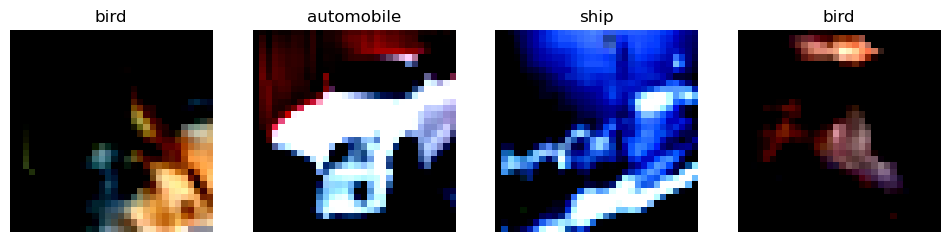

In [26]:
WIDTH = 32
HEIGH = 32

n_imgs = 4

fig, axs = plt.subplots(1,n_imgs,figsize=(12,3));
for i,ax in enumerate(axs):
    im = trainset[i]
    ax.imshow(im[0].data.numpy().transpose((1,2,0)), cmap='gray'); 
    ax.set_title(name_classes[im[1]]); 
    ax.axis('off')
plt.show()

After datasets initialization we must crate dataloaders (generators of batches).

In [27]:
BATCH_SIZE = 64

if torch.cuda.is_available():
    kwarg = {'generator':torch.Generator(device='cuda')}
else:
     kwarg = {'num_workers':0}

trainloader = data.DataLoader(trainset,shuffle=True,batch_size=BATCH_SIZE, **kwarg)

validloader = data.DataLoader(validset,batch_size=BATCH_SIZE, **kwarg)

testloader  = data.DataLoader(testset,batch_size=BATCH_SIZE, **kwarg)

So we can visualize the dataset
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


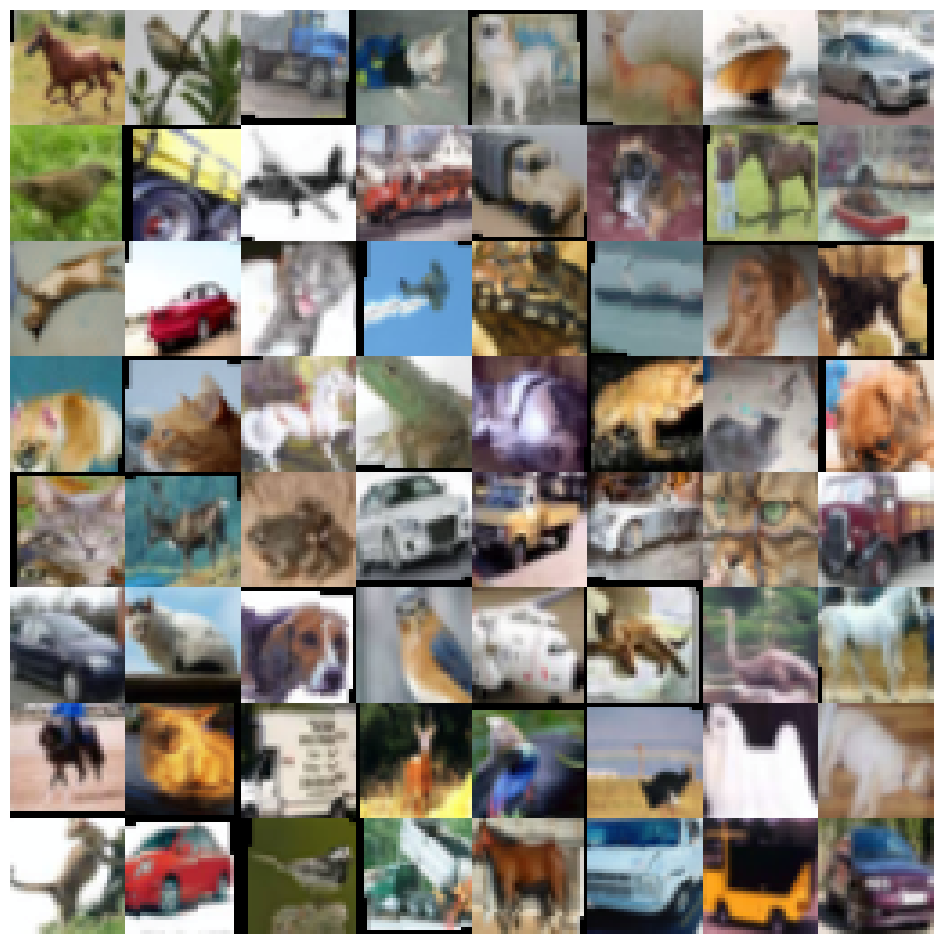

first raw classes horse  bird truck   dog   dog  deer  ship automobile
torch.Size([64, 3, 32, 32])


In [31]:
def imshow(images, nrow = 8,figsize=(16,12), mean=MEAN, std=STD):
    
    img = torchvision.utils.make_grid(images, nrow = nrow, padding = 0).to(device)

    img = img.transpose(2,0).transpose(0,1)

    std = torch.as_tensor(std).to(device)
    mean = torch.as_tensor(mean).to(device)
    img = (img * std + mean)# unnormalize 
    
    img = img.data.cpu().numpy()
       
    plt.figure(figsize=(16,12))
    plt.imshow(img); plt.axis('off'); plt.show()


images, labels = next(iter(trainloader))

imshow(images)

print('first raw classes',' '.join('%5s' % names_classes[labels[j]] for j in range(BATCH_SIZE//8)))

print(images.shape)

Now let's describe the model. For that  we will use classical `LeNet` model. 
![](https://production-media.paperswithcode.com/methods/LeNet_Original_Image_48T74Lc.jpg)

The network consits in: <ul>
<li> input image 32х32 ( for us 3х32х32),
<li> two conv layers, 
<li> each conv layer has pooling after,
<li> flat - vectorization layer,
<li> two full-connected layers,
<li> output layer - softmax classification with 10 outputs.
</ul>
The features of architecture:<ul>
<li> valid convolution (without padding, with size reduction)$^*$;
<li> each conv kernel has size 5х5 (kernel size = 5);
<li> maxpooling with stride 2 and tiles 2х2;
<li> first layer output has 6 feature maps with size 14х14 (after pooling);
<li> second conv layer 16 feature maps with size 5х5 (after pooling);
<li> flat layer take 16 maps 5х5 and give $1х16*5*5$ (1х400);
<li> first full-connected layer give 120 outputs;
<li> second full-connected layer give 84 outputs.
</ul>
   For studying aim let's add dropout and batchnorm also.   
$^*$the output of conv layer size can be calculated as: W=(W−F+2P)/S+1, where W is input size, F is kernel size, S is stride applied, and P is padding. 
   

In [32]:
class LeNet(nn.Module):
    
    def __init__(self, in_channels, n_classes):
        super().__init__()
        
        self.in_channels = in_channels
        self.n_classes   = n_classes
        
        # convolution
        self.conv1   = nn.Conv2d(in_channels  = self.in_channels, 
                                 out_channels = 6, 
                                 kernel_size  = 5)
                                        

        self.conv2   = nn.Conv2d(in_channels  = 6, 
                                 out_channels = 16,
                                 kernel_size  = 5)
        
        # pooling
        self.pool = nn.AvgPool2d(kernel_size = 2, 
                                 stride      = 2)
        
        # classification
        self.fc1 = nn.Linear(in_features  = 16 * 5 * 5, 
                             out_features = 120)
        
        self.fc2 = nn.Linear(in_features  = 120, 
                             out_features = 84)
        
        self.fc_out = nn.Linear(in_features = 84, 
                                out_features = self.n_classes)

    def flatten(self, x):
        # 16 feature map with size 5 x 5
        return x.view(-1, 16 * 5 * 5) 
    
    def forward(self, x):
        
        # 1-st layer
        x = self.conv1(x)
        x = torch.tanh(x) + 0.001*x       
        x = self.pool(x)
        
        #2-nd layer
        x = self.conv2(x)         
        x = torch.tanh(x) + 0.001*x        
        x = self.pool(x)

        #flatten
        x = self.flatten(x)
        
        # 1-st fc layer
        x = self.fc1(x)
        x = torch.tanh(x) + 0.001*x
        
        # 2-nd fc layer
        x = self.fc2(x)
        x = torch.tanh(x) + 0.001*x
        
        # output layer
        x = self.fc_out(x)
        
        return x#torch.softmax(x, dim=1)

Actually we could describe the model with container sequential, like it is shown below, but it could be problematic in farther.
```python
model = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5, padding=2), 
            nn.Tanh(),
            nn.AvPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5), 
            nn.Tanh(),
            nn.AvPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(16 * 5 * 5, 120),
            nn.Tanh(),
            nn.Linear(120, 84), 
            nn.Tanh(),
            nn.Linear(84, 10)
            )
```

In [33]:
model = LeNet(3,10)

from torchinfo import summary
summary(model, input_size = (1,3,32,32))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet                                    [1, 10]                   --
├─Conv2d: 1-1                            [1, 6, 28, 28]            456
├─AvgPool2d: 1-2                         [1, 6, 14, 14]            --
├─Conv2d: 1-3                            [1, 16, 10, 10]           2,416
├─AvgPool2d: 1-4                         [1, 16, 5, 5]             --
├─Linear: 1-5                            [1, 120]                  48,120
├─Linear: 1-6                            [1, 84]                   10,164
├─Linear: 1-7                            [1, 10]                   850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.66
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 0.25
Estimated Total Size (MB): 0.31

In [34]:
params = list(model.named_parameters())

# print(params)
for idx in range(len(params)):
    print(params[idx][0],'\t', params[idx][1].size()) 
print('\n',10*'--')
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of trainable parameters for the model: %d' % (num_params))

num_params = sum(p.numel() for p in model.parameters() )
print('Number of all parameters for the model: %d' % (num_params))

conv1.weight 	 torch.Size([6, 3, 5, 5])
conv1.bias 	 torch.Size([6])
conv2.weight 	 torch.Size([16, 6, 5, 5])
conv2.bias 	 torch.Size([16])
fc1.weight 	 torch.Size([120, 400])
fc1.bias 	 torch.Size([120])
fc2.weight 	 torch.Size([84, 120])
fc2.bias 	 torch.Size([84])
fc_out.weight 	 torch.Size([10, 84])
fc_out.bias 	 torch.Size([10])

 --------------------
Number of trainable parameters for the model: 62006
Number of all parameters for the model: 62006


In [35]:
X = torch.randn(1, 3, 32, 32) # Batch Size x Channels x Wide x Height
out = model(X)
print(out.data.cpu().numpy(), '\n max position (Class index):', out.argmax().item())

[[ 0.03248885 -0.08538094  0.08505696 -0.00600408 -0.1266203  -0.0527396
   0.09110764  0.03694598 -0.08875008  0.08787075]] 
 max position (Class index): 6


Let's define setting of training.

For determin accuacy during the training and evaluation stages we can create the following function.

In [37]:
def initialize_parameters(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.constant_(m.bias.data, 0)

In [38]:
model.apply(initialize_parameters);

__MEASURE__ (__metric__)

In [36]:
def accuracy(y_pred, y):
    cls_pred = y_pred.argmax(1, keepdim=True)    
    correct_cls = cls_pred.eq(y.view_as(cls_pred)).sum()
    acc = correct_cls.float() / y.shape[0]
    return acc

Now we can describe the train step (epoch).

In [54]:
def train(model, dataloader, optimizer, criterion, metric,  device):

    epoch_loss = 0
    epoch_acc  = 0

    model.train()

    for (x, y) in tqdm(dataloader, desc="Training", leave=False):

        x, y = x.to(device).float(), y.to(device).long()

        optimizer.zero_grad(set_to_none = True)

        y_pred = model(x) #model.forward(x)

        loss = criterion(y_pred, y)
        acc  = metric(y_pred, y)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc  += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

Similary to above one we can describe the evaluate function.

In [55]:
def evaluate(model, dataloader, criterion, metric, device):

    epoch_loss = 0
    epoch_acc  = 0

    model.eval()

    with torch.no_grad():
        
        for (x, y) in tqdm(dataloader, desc="Evaluating", leave=False):

            x, y = x.to(device).float(), y.to(device).long()

            y_pred = model.forward(x) #model(x)

            loss = criterion(y_pred, y)
            acc  = metric( y_pred, y)

            epoch_loss += loss.item()
            epoch_acc  += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

In addition we will need function to estiamte epoch time.

In [56]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Now we can describe setting for our model

In [57]:
LR_PERIOD = 2
LR_DECAY  = 0.9
LR = 0.003;
EPOCHS = 20

model     = LeNet(3,10)
criterion = nn.CrossEntropyLoss()
metric    = accuracy


model     = model.to(device)
criterion = criterion.to(device)

# trainable_parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=LR)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                            step_size = LR_PERIOD, 
                                            gamma     = LR_DECAY)

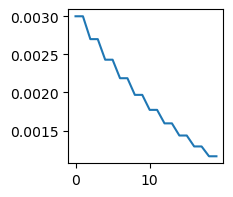

In [58]:
lrs = np.zeros((EPOCHS))
plt.figure(figsize=(2,2));

with torch.inference_mode():
    for i in range(EPOCHS):
        optimizer.step()
        lrs[i] = optimizer.param_groups[0]["lr"]
        scheduler.step()

    plt.plot(range(EPOCHS),lrs); 
    

now we can see the summary

In [ ]:
# for name, param in model.named_parameters():
#     print(name, '\t structure =',list(param.size()))

In [60]:
# for name, child in model.named_children():
#     print(name, '\t structure =',list(child.size()))

Let's start traing, as it shown below.Our fitting algorithm includes training and evaluation in each epoch, and also routine of searching the best epoch by accuracy on validation data.

In [78]:
def fit(model, train_loader, val_loader, optimizer, criterion, metric, epochs = 10, 
        device='cpu', scheduler = None,  path_best = 'best_model.pt', verbose = True):
    
    best_valid_loss = float('inf')
    history = {'train_loss':np.zeros(epochs),
               'valid_loss':np.zeros(epochs),
               'train_acc':np.zeros(epochs),
               'valid_acc':np.zeros(epochs)}
    
    for epoch in trange(epochs):

        start_time = time.monotonic()

        train_loss, train_acc = train(model, train_loader, optimizer, criterion, metric, device)
        valid_loss, valid_acc = evaluate(model, val_loader, criterion, metric, device)
        
        if scheduler != None:
            scheduler.step()
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), path_best)
        
        end_time = time.monotonic()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)       
    
        if verbose == True:
            if epoch%2 == 1:    # print every 2 epochs:
                print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s | LR {optimizer.param_groups[0]["lr"] :.4f}')
                print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%',
                f' | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%') 
  
        history['train_loss'][epoch] = train_loss 
        history['valid_loss'][epoch] = valid_loss 
        history['train_acc'][epoch] = train_acc 
        history['valid_acc'][epoch] = valid_acc 
    return history

In [79]:
history = fit(model, trainloader, validloader, optimizer, criterion, metric, epochs = EPOCHS, 
                device=device, scheduler = scheduler,  path_best = 'best_model.pt', verbose = True)

  0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/462 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Training:   0%|          | 0/462 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 15s | LR 0.0007
	Train Loss: 1.450 | Train Acc: 47.53%  | Val. Loss: 1.491 | Val. Acc: 45.71%


Training:   0%|          | 0/462 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Training:   0%|          | 0/462 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 15s | LR 0.0006
	Train Loss: 1.436 | Train Acc: 47.92%  | Val. Loss: 1.468 | Val. Acc: 47.09%


Training:   0%|          | 0/462 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Training:   0%|          | 0/462 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 16s | LR 0.0006
	Train Loss: 1.426 | Train Acc: 48.11%  | Val. Loss: 1.467 | Val. Acc: 46.64%


Training:   0%|          | 0/462 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Training:   0%|          | 0/462 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 15s | LR 0.0005
	Train Loss: 1.417 | Train Acc: 48.63%  | Val. Loss: 1.469 | Val. Acc: 46.76%


Training:   0%|          | 0/462 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Training:   0%|          | 0/462 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 16s | LR 0.0005
	Train Loss: 1.405 | Train Acc: 49.22%  | Val. Loss: 1.449 | Val. Acc: 47.65%


Training:   0%|          | 0/462 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Training:   0%|          | 0/462 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 16s | LR 0.0004
	Train Loss: 1.399 | Train Acc: 49.26%  | Val. Loss: 1.438 | Val. Acc: 47.48%


Training:   0%|          | 0/462 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Training:   0%|          | 0/462 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 35s | LR 0.0004
	Train Loss: 1.391 | Train Acc: 49.83%  | Val. Loss: 1.444 | Val. Acc: 47.98%


Training:   0%|          | 0/462 [00:00<?, ?it/s]

KeyboardInterrupt: 

We can visualize results of training by the following routine.

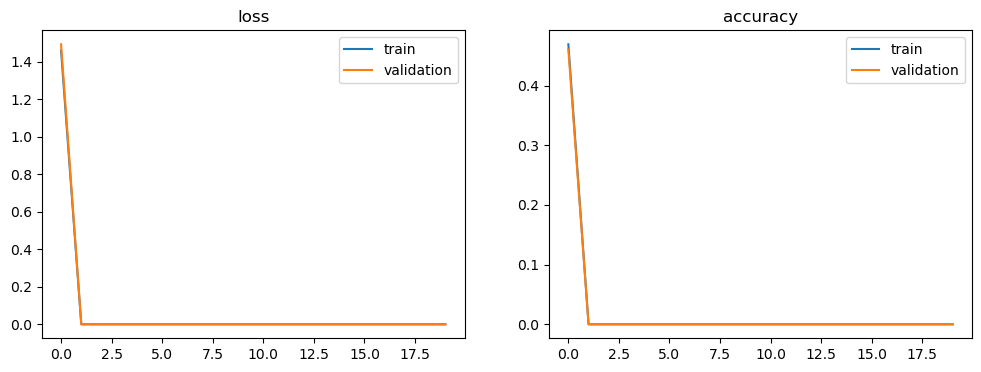

In [83]:
def plot_results(history):
    fig,axs = plt.subplots(1,2,figsize = (12,4))
    axs[0].plot(history['train_loss'], label = 'train')
    axs[0].plot(history['valid_loss'], label = 'validation')
    axs[0].set_title('loss')
    axs[0].legend()
    axs[1].plot(history['train_acc'], label = 'train')
    axs[1].plot( history['valid_acc'], label = 'validation')
    axs[1].set_title('accuracy')
    axs[1].legend()
    plt.show()

plot_results(history )

save results

In [84]:
PATH = './cifar_net.pth'
torch.save(model.state_dict(), PATH)

download results

In [86]:
model = LeNet(3,10)
model.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

Test results for best epoch

In [90]:
model.load_state_dict(torch.load('best_model.pt', weights_only=True))
test_loss, test_acc = evaluate(model, testloader, criterion, metric, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 1.313 | Test Acc: 52.50%


In [106]:
def inference_model(model, dataloader, device = 'cpu'):
    
    model.eval()
    dataiter = iter(dataloader)
    images, labels = next(dataiter)
    with torch.no_grad():
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
    return outputs

outputs = inference_model(model, testloader, device = device)
    # (outputs)

and learn predictions

In [107]:
_, predicted = torch.max(outputs, 1)
print(predicted)

tensor([3, 8, 8, 8, 4, 6, 1, 6, 5, 1, 8, 9, 3, 7, 9, 8, 5, 7, 8, 6, 7, 2, 2, 9,
        2, 2, 3, 9, 9, 6, 3, 4, 6, 3, 9, 3, 2, 1, 9, 5, 1, 6, 5, 6, 8, 9, 3, 9,
        4, 4, 9, 8, 6, 6, 8, 8, 7, 6, 5, 3, 7, 3, 4, 9])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


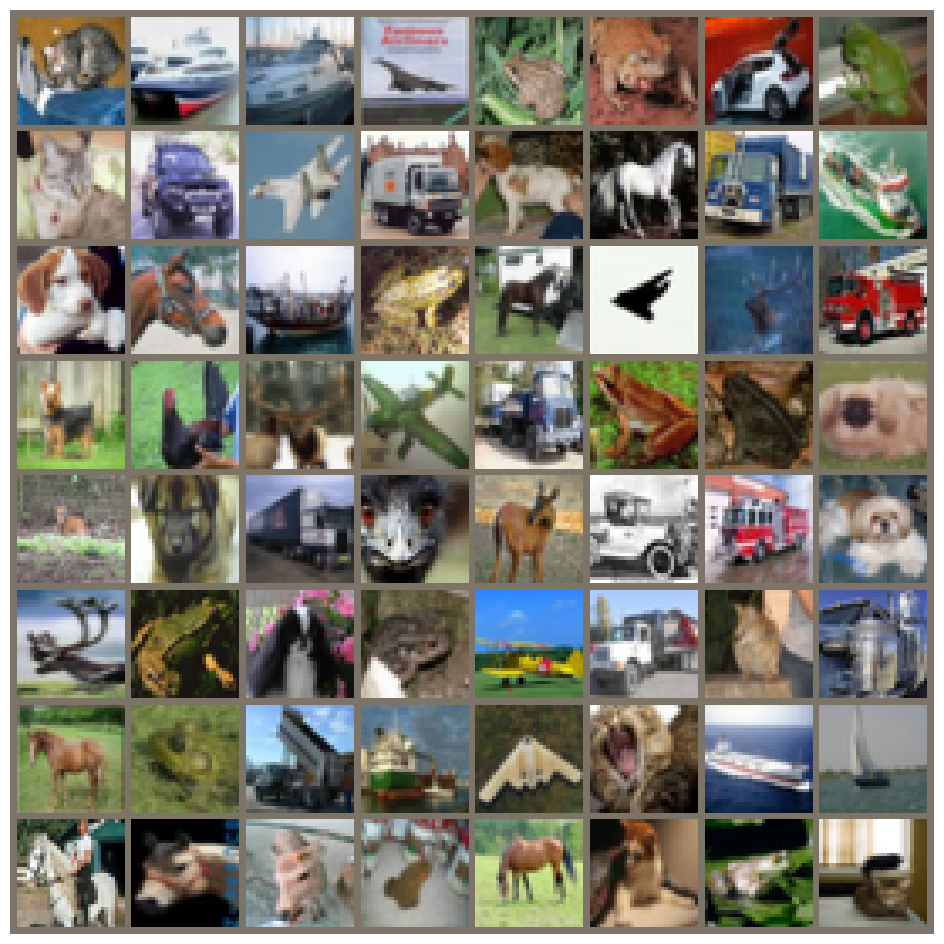

GroundTruth:    cat  ship  ship airplane
Predicted :     cat  ship  ship  ship


In [108]:
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % names_classes[labels[j]] for j in range(4)))
print('Predicted :  ', ' '.join('%5s' % names_classes[predicted[j]] for j in range(4)))

Let's test the accuracy as number of correct prediction to all

In [109]:
n_classes = 10
n_samples = len(testset)

class_correct = torch.zeros(n_classes)
class_total   = torch.zeros(n_classes)

labels   = []
predicts = []

model.eval()

with torch.no_grad():
    
    for x,y in tqdm(testloader):
        x = x.to(device)
        y = y.to('cpu')

        y_pred = model.forward(x).to('cpu')
        
        cls_pred = torch.argmax(y_pred, dim=1)
        
        c = (cls_pred == y).squeeze() # one-hot vector
        
        for i in range(x.shape[0]):
            label = y[i]
            class_correct[label] += c[i].item()
            class_total[label]   += 1
    
        labels.append(y)
        predicts.append(cls_pred)
        
labels   = torch.cat(labels, dim = 0) # make it 1d array
predicts = torch.cat(predicts, dim = 0) # make it 1d array
    
for i in range(n_classes):
    print('Accuracy of %5s : %2d %%' % (
        names_classes[i], 100 * class_correct[i] / class_total[i]))

  0%|          | 0/157 [00:00<?, ?it/s]

Accuracy of airplane : 53 %
Accuracy of automobile : 64 %
Accuracy of  bird : 34 %
Accuracy of   cat : 38 %
Accuracy of  deer : 38 %
Accuracy of   dog : 40 %
Accuracy of  frog : 62 %
Accuracy of horse : 63 %
Accuracy of  ship : 68 %
Accuracy of truck : 63 %


Also you may represent the results as correlation (heat) map

In [110]:
def plot_confusion_matrix(labels, pred_labels, names_classes):
    
    fig, ax = plt.subplots(figsize=(10, 10))
    
    cm = confusion_matrix(np.asarray(labels, dtype=int), 
                          np.asarray(pred_labels, dtype=int) )
    
    cm = ConfusionMatrixDisplay(cm, display_labels=names_classes)
    
    cm.plot(values_format='d', cmap='coolwarm', ax=ax)

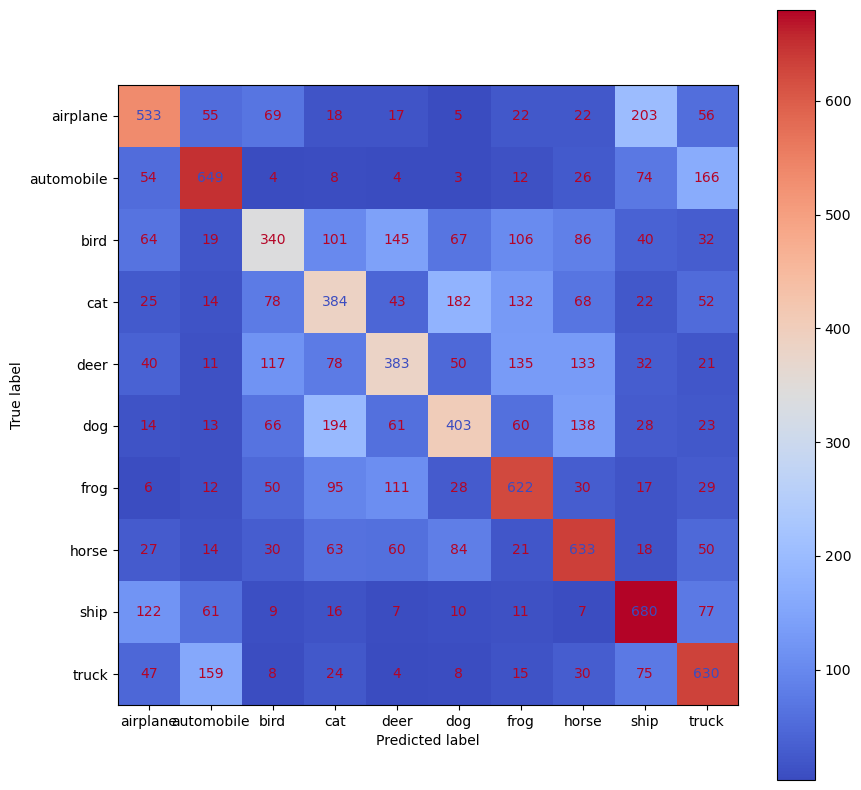

In [111]:
plot_confusion_matrix(labels, predicts, names_classes)

IF you want to store the results you may also use this code

In [112]:
sorted_ids = list(range(1, n_samples + 1)) 

sorted_ids.sort(key=lambda x: str(x))

df = pd.DataFrame({'id': sorted_ids, 'label': predicts})

df['label'] = df['label'].apply(lambda x: names_classes[x])

df.to_csv('submission.csv', index=False)

For some research proposed we can visualize features or weights for each layer, like it is shown below.

In [116]:
def plot_filtered_images(images, filters ):

    images = torch.cat([i.unsqueeze(0) for i in images], dim=0).cpu()
    
    print(images.shape)
    
    filters = filters.cpu()

    n_images  = images.shape[0]
    n_filters = filters.shape[0]

    filtered_images = F.conv2d(images, filters)#, groups=3)
    
    fig = plt.figure(figsize=(20, 20))

    for i in range(n_images):

        img = images[i].squeeze(0).numpy().transpose((1,2,0))
        
        img = 255*(img - img.min())/(img.max() - img.min())

        ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters))
        
        ax.imshow(img.astype(int), cmap='bone')
        ax.set_title('Original')
        ax.axis('off')

        for j in range(n_filters):
            image = filtered_images[i][j]
            
            image = image.numpy().astype(float)
            
            image = 255*(image - image.min())/(image.max() - image.min())
            
            ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters)+j+1)
            
            ax.imshow(image.astype(int), cmap='bwr', interpolation='bilinear')
            
            ax.set_title(f'Filter {j+1}')
            ax.axis('off')
    return filtered_images

torch.Size([10, 3, 32, 32])


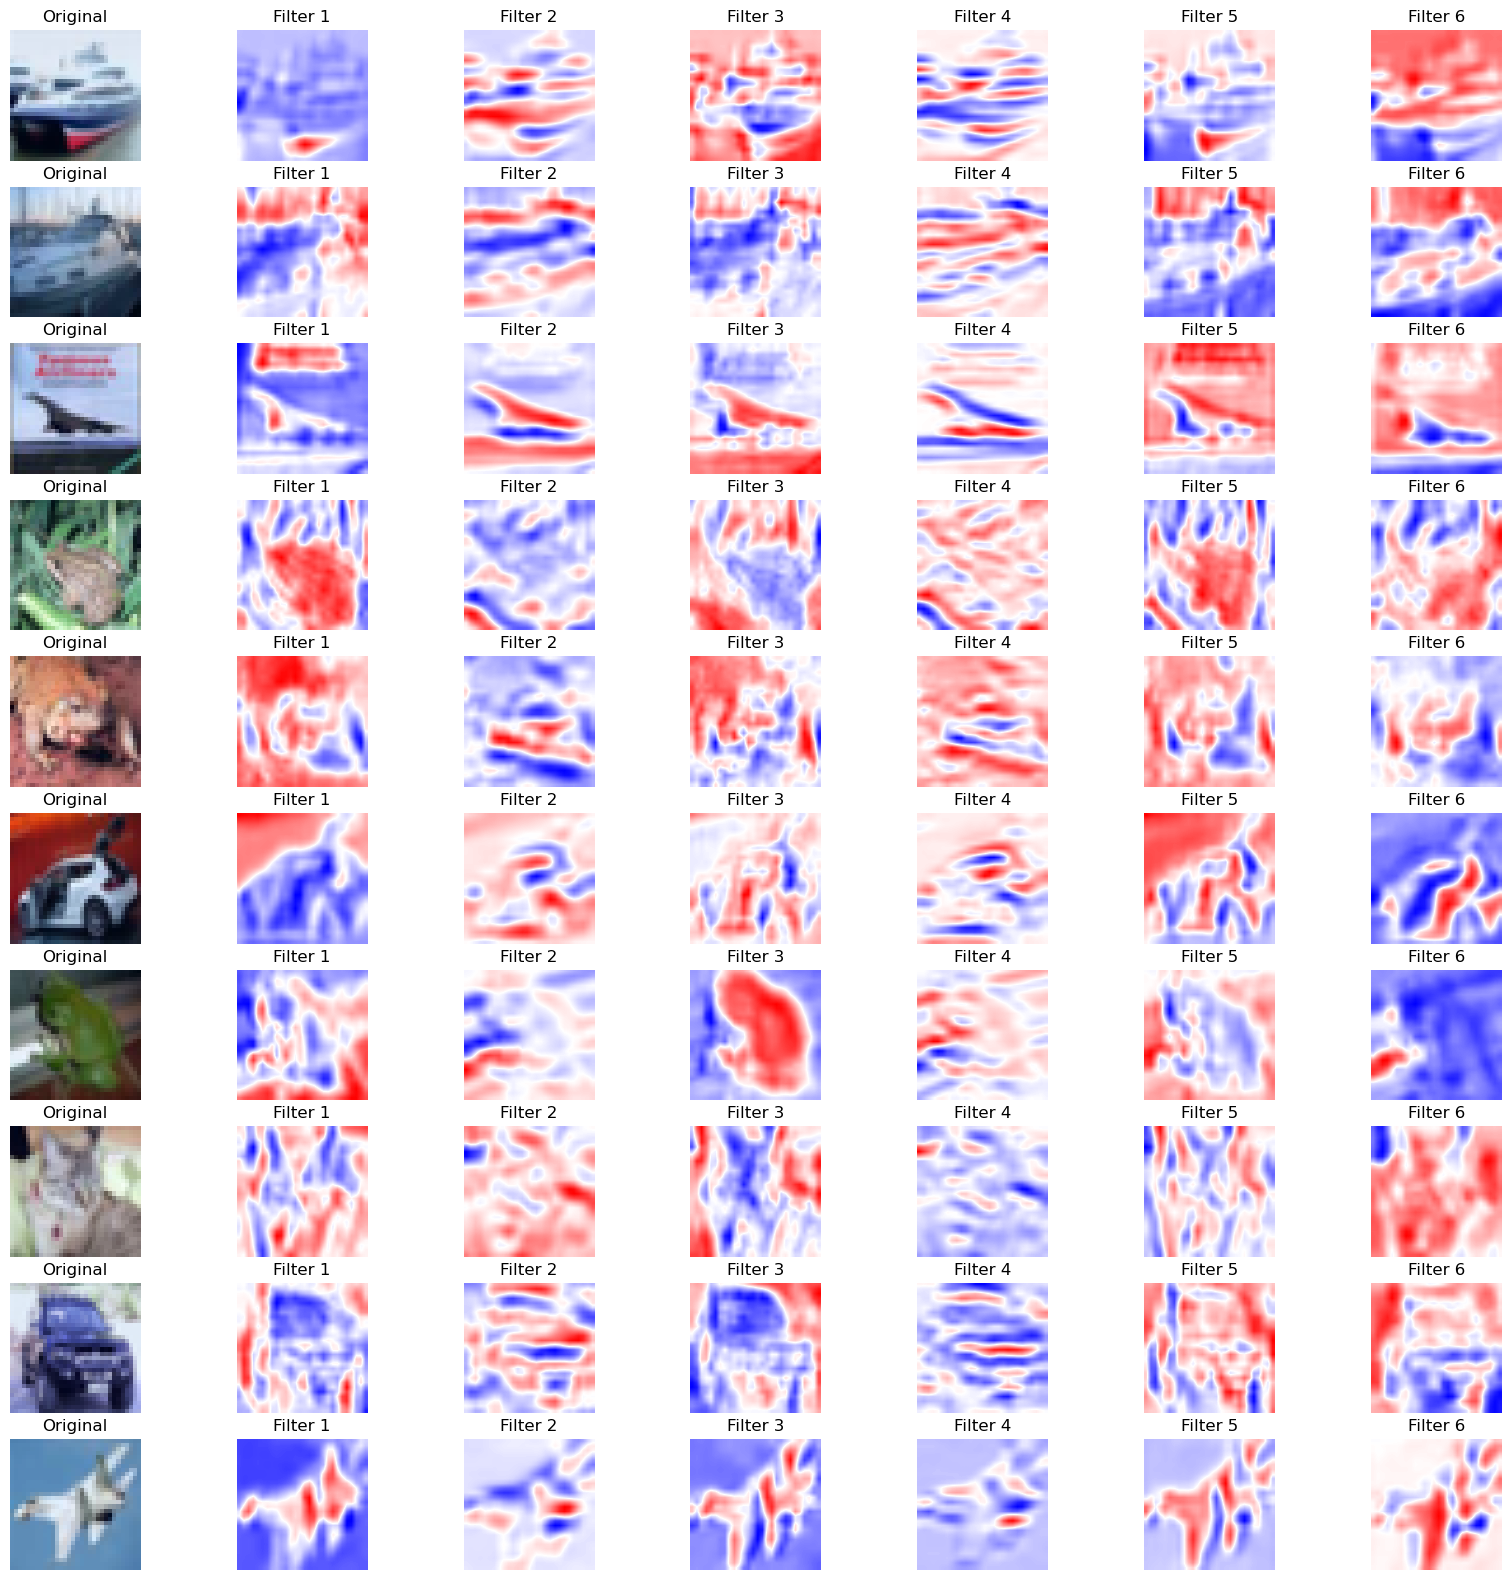

In [117]:
N_IMAGES = 10

images = [image for image, label in [testset[i+ 1] for i in range(N_IMAGES )]]

filters = model.conv1.weight.data

filtered_images = plot_filtered_images(images, filters)

and for filters.

In [118]:
def plot_filters(filters):

    filters = filters.cpu()

    n_filters = filters.shape[0]

    fig = plt.figure(figsize=(20, 10))

    for i in range(n_filters):
        filt = filters[i].squeeze(0).numpy().transpose((1,2,0))
        ax = fig.add_subplot(1, n_filters, i+1)
        ax.imshow(filt[:,:,1], cmap='bone')
        ax.axis('off')

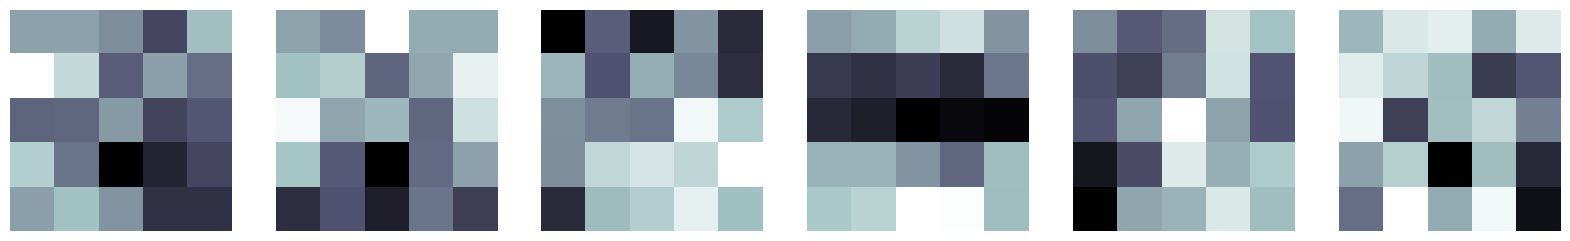

In [119]:
filters = model.conv1.weight.data
plot_filters(filters)

*Exercise 1* <br>
Add the early stop to the fitting by condition: valid loss does not decrease 3 epochs.

*Exercise 2* <br>
 Analyze the results and drop the class with the least accurate, then try training again, what's happen?

*Exercise 3* <br>
 Try to decrease the model size by removing the largest layer and see how it affect on the inference time and accuracy 

*Exercise 4* <br>
Try to train the model with  ADAM optimizations, shown above and compare the results


*Exercise 5*
1. Replace average pooling with maxpooling and comapre the results
2. Replace tanh activation with ReLU one and comapre the results